<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/algorithm/linalg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 線形方程式の求解

In [ ]:
%reset -f

### 直接法  

#### LU分解

LU分解$A=PLU$を求める。
$P$は置換行列$P^2=I$、$L$は対角成分1の下三角行列、$U$は上三角行列。

LU分解を求める過程には部分ピボット選択付きガウスの消去法から求める外積形式ガウス法や、$A=PLU$から直接成分を比較して求める内積形式ガウス法が存在。ここでは[外積形式ガウス法](https://cedddnav.org/raspi4a/)を使用。
この方法は部分ピボット選択付きガウスの消去法を$L^{-1}PA=U$と比較して$P,L,U$を求める。$P$は最終的な部分ピボット選択全体。$L$は行基本変形の積の逆行列であり、各行基本変形の逆行列が非対角成分の符号を反転させたものであることを利用。

$A\vec{x}=PLU\vec{x}=\vec{b}⇔LU\vec{x}=P\vec{b}$であるので
、$L\vec{y}=P\vec{b}, U\vec{x}=\vec{y}$として代入操作で解けば、
これは前進・後退代入に対応。

ランダムに生成した正方行列で検証。numpy の LU 分解の機能を使う。
（非正方行列は[疑似逆行列の計算法](https://www.momoyama-usagi.com/entry/math-linear-algebra-ap08)を適用したものとする。）

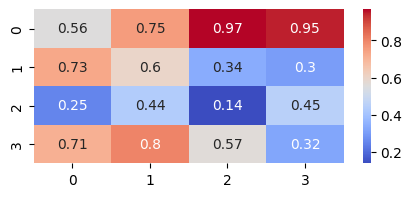

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 表示の精度を設定
np.set_printoptions(precision=3, suppress=False)
plt.rcParams['figure.figsize'] = (5, 2)

N = 4
A = np.random.rand(N, N)
sns.heatmap(A, annot=True, cmap='coolwarm')
plt.show()

部分ピボット選択付きガウスの消去法で LU 分解を実装

P:


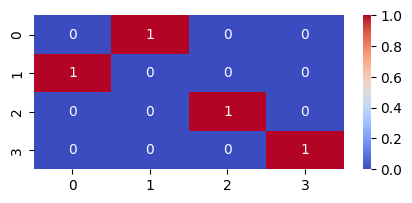

L:


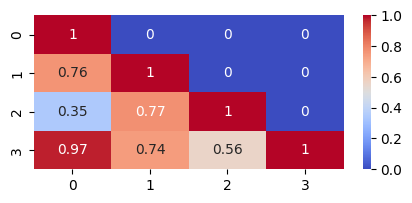

U:


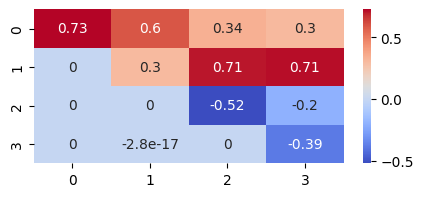

In [ ]:
def lu_decomposition(A):
  N = A.shape[0]
  # P：単位行列 -> 置換行列
  # L：単位行列 -> 行基本変形
  # U：元の行列 -> 前進消去後の行列
  P, L, U =  np.eye(N), np.eye(N), A.copy()

  # 列ループ
  for j in range(N-1):
    # 部分ピボット選択.
    # idx 列の [idx, N-1] 行のうち最も大きな成分を選択.
    pivot = j + np.argmax(abs(U[j:, j]))

    # 除算によるオーバーフロー, 0除算エラーを防ぐ.
    if np.isclose(U[pivot, j], 0):
      raise ValueError("Singular matrix")

    if pivot != j:
      # i 行と pivot 行を入れ替える
      U[[j, pivot]] = U[[pivot, j]]
      # 置換行列の更新
      P[[j, pivot]] = P[[pivot, j]]
      if j > 0:
        # 前進消去の履歴も合わせて置換
        L[[j, pivot], :j] = L[[pivot, j], :j]

    # 行ループ（対角より下）
    for i in range(j+1, N):
      # 行基本変形の逆行列 (基本変形から符号反転)
      L[i, j] = U[i, j] / U[j, j]
      # 基本変形で前進消去 (基本変形なので符号を戻す)
      U[i, j:] -= L[i, j] * U[j, j:]
  return P, L, U

P, L, U = lu_decomposition(A)

print("P:")
sns.heatmap(P, annot=True, cmap='coolwarm')
plt.show()
print("L:")
sns.heatmap(L, annot=True, cmap='coolwarm')
plt.show()
print("U:")
sns.heatmap(U, annot=True, cmap='coolwarm')
plt.show()


scipy で検算

δP:


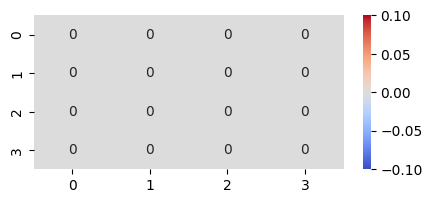

δL:


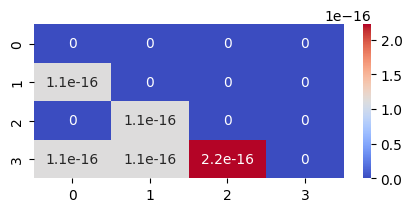

δU:


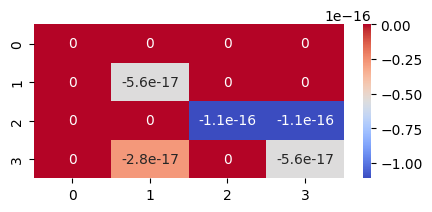

In [ ]:
import scipy.linalg as linalg
P2, L2, U2 = linalg.lu(A)

print("δP:")
sns.heatmap(P-P2, annot=True, cmap='coolwarm')
plt.show()
print("δL:")
sns.heatmap(L-L2, annot=True, cmap='coolwarm')
plt.show()
print("δU:")
sns.heatmap(U-U2, annot=True, cmap='coolwarm')
plt.show()

分解が正しいか検算

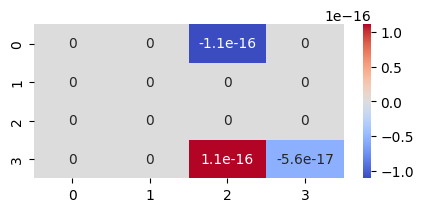

In [ ]:
residuals = A - P @ L @ U
sns.heatmap(residuals, annot=True, cmap='coolwarm')
plt.show()

ここから$A\vec{x}=\vec{b}$を解くために$\vec{b}$を生成

In [ ]:
b = np.random.rand(N)
print(f"{b=}")

b=array([0.447, 0.563, 0.569, 0.232])


$L\vec{y}=P^T\vec{b}$ を解く。
前進代入は$y_i=b'_i-\sum_{j=0}^{i-1}l_{ij}y_j$。

In [ ]:
def forward_substitute(P, L, b):
    y = np.zeros(N)
    for i in range(N):
        y[i] = (P.T @ b)[i] - L[i, :i] @ y[:i]
    return y

y = forward_substitute(P, L, b)
print(f"{y=}")

y=array([ 0.563,  0.017,  0.362, -0.53 ])


$U\vec{x}=\vec{y}$ を解く。
後退代入は$x_i=(y_i-\sum_{j=i+1}^nu_{ij}x_j)/u_{ii}$。

In [ ]:
def backward_substitute(U, y):
    x = np.zeros(N)
    for i in range(N-1, -1, -1):
        x[i] = (y[i] - U[i, i+1:] @ x[i+1:]) / U[i, i]
    return x

x = backward_substitute(U, y)
print(f"{x=}")

x=array([ 1.02 , -0.299, -1.224,  1.361])


解の検算を実施

In [ ]:
residuals = A @ x - b
print(residuals)

[1.110e-16 1.110e-16 0.000e+00 8.327e-17]


逆行列もLU分解から求まる。$AA^{-1}=I$なので$A\vec{x}_i=\vec{e}_i$を解けばいい。これは他の手法でも同じ。

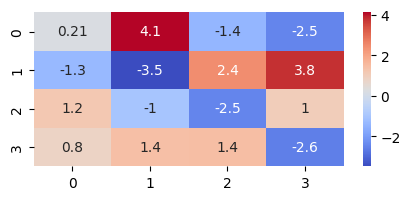

In [ ]:
Ainv = np.zeros_like(A)
for i in range(N):
    e = np.zeros(N)
    e[i] = 1
    y = forward_substitute(P, L, e)
    x = backward_substitute(U, y)
    Ainv[:, i] = x

sns.heatmap(Ainv, annot=True, cmap='coolwarm')
plt.show()

逆行列の検算

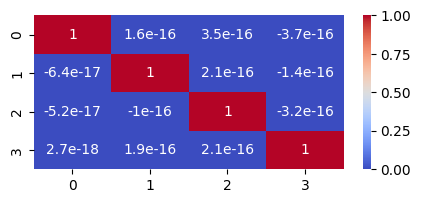

In [ ]:
sns.heatmap(A @ Ainv, annot=True, cmap='coolwarm')
plt.show()

#### コレスキー分解法

解くべき連立一次方程式$A\vec{x}=\vec{b}$の係数行列$A$が非負定値ならコレスキー分解が可能なので、これを利用。

不定値なら$(A^TA)\vec{x}=A^T\vec{b}$を解く。$A^TA$は必ず対称で非負定値(特異値分解の部分を参照)。

### 間接法

間接法は反復更新で解に収束させることで解く。
共役勾配法なら2次形式の最適化問題に変形して適用。

## 特異値分解

In [ ]:
%reset -f

### 右特異ベクトル

行列 $A$ に対して行列 $A^TA$ を考える。
明らかに $(A^TA)^T=A^TA$ なので対称行列。
[スペクトル定理](https://ja.wikipedia.org/wiki/%E3%82%B9%E3%83%9A%E3%82%AF%E3%83%88%E3%83%AB%E5%AE%9A%E7%90%86)より固有値は常に実数である。

また行列 $A$ の非負定値の条件は任意の $\vec{x}\neq\vec{0}$ に対して $\vec{x}^TA\vec{x}\geq0$。
よって任意の $A, \vec{x}\neq\vec{0}$ に対して $\vec{x}^T(A^TA)\vec{x}=||A\vec{x}||^2\geq0$。
これより固有値は常に非負である。そのため固有値の平方根も常に実数である。

これは $AA^T$ でも同様に成立。

実際に確かめるために乱数生成の行列でこれを計算。

<Axes: >

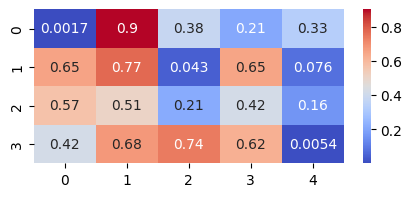

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 表示の精度を設定
np.set_printoptions(precision=3, suppress=False)
plt.rcParams['figure.figsize'] = (5, 2)

N, M = 4, 5
A = np.random.rand(N, M)
sns.heatmap(A, annot=True, cmap='coolwarm')

$A^TA$ は対称行列

<Axes: >

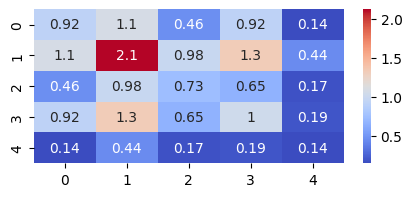

In [ ]:
ATA = A.T @ A
sns.heatmap(ATA, annot=True, cmap='coolwarm')

固有値はすべて実数で非負（数値誤差に注意）

w_right=array([ 4.247e+00,  4.407e-01,  2.392e-01,  2.753e-02, -2.831e-18])


<Axes: >

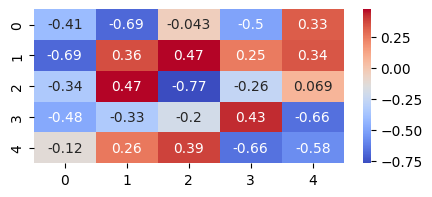

In [ ]:
import numpy.linalg as la

w_right, V = la.eigh(ATA)
# 固有値が大きい順
w_right, V = w_right[::-1], V[:, ::-1]
print(f"{w_right=}")
sns.heatmap(V, annot=True, cmap='coolwarm')

固有ベクトルは$V$の各列が対応。
検算で $\vec{v}^T(A^TA)\vec{v}-w$ を計算。

<Axes: >

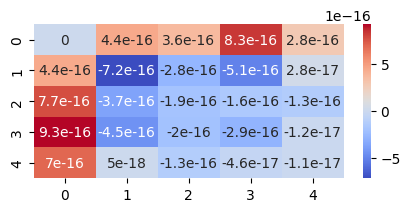

In [ ]:
residuals = V.T @ ATA @ V - np.diag(w_right)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

$V$ 行列は直交行列(ユニタリー行列)で[右特異ベクトル](https://manabitimes.jp/math/1280#5)

<Axes: >

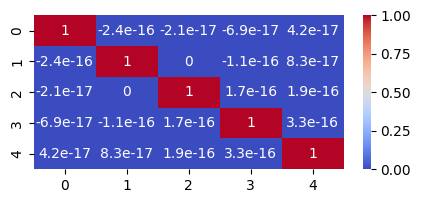

In [ ]:
import seaborn as sns

# 検算。ユニタリなら単位行列に近くなる。
sns.heatmap(V.T @ V, annot=True, cmap='coolwarm')

### 左特異ベクトル

同様に $AA^T$ について計算し左特異ベクトル$U$を求める

w_left=array([4.247, 0.441, 0.239, 0.028])


<Axes: >

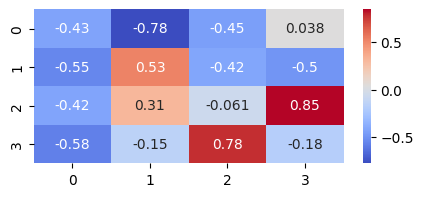

In [ ]:
AAT = A @ A.T
w_left, U = la.eigh(AAT)
# 固有値が大きい順
w_left, U = w_left[::-1], U[:, ::-1]

print(f"{w_left=}")
sns.heatmap(U, annot=True, cmap='coolwarm')

左特異ベクトルを検算

<Axes: >

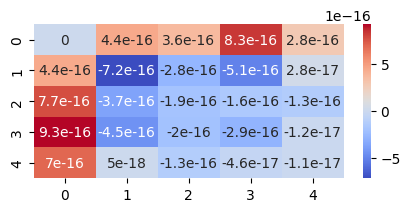

In [ ]:
residuals = V.T @ ATA @ V - np.diag(w_right)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

<Axes: >

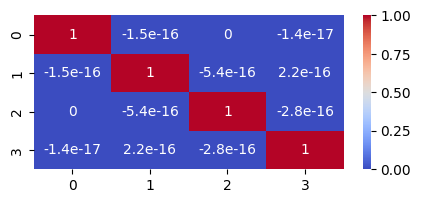

In [ ]:
sns.heatmap(U.T @ U, annot=True, cmap='coolwarm')

### 特異値分解

数値誤差の対策。ほぼ0は0とする。

In [ ]:
w_right = np.array([w if abs(w) > 1e-10 else 0 for w in w_right])
w_left = np.array([w if abs(w) > 1e-10 else 0 for w in w_left])
print(f"{w_right=}")
print(f"{w_left=}")

w_right=array([4.247, 0.441, 0.239, 0.028, 0.   ])
w_left=array([4.247, 0.441, 0.239, 0.028])


$A^TA, AA^T$ の固有値の平方根は特異値

In [ ]:
sigma_right = np.sqrt(w_right)
sigma_left = np.sqrt(w_left)
print(f"{sigma_right=}")
print(f"{sigma_left=}")

sigma_right=array([2.061, 0.664, 0.489, 0.166, 0.   ])
sigma_left=array([2.061, 0.664, 0.489, 0.166])


特異値による行列 $\Sigma$ を作成

In [ ]:
Sigma = np.zeros_like(A)
sigma = sigma_right if len(sigma_right) < len(sigma_left) else sigma_left
Sigma[:len(sigma), :len(sigma)] = np.diag(sigma)
print(f"{Sigma=}")

Sigma=array([[2.061, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.664, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.489, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.166, 0.   ]])


固有ベクトルには符号の不定性があるためそのままでは$A=U\Sigma V^T$を満たすとは限らない。

$\Sigma$の成分は非負なので$(AV)_i=\lambda_iU_i, \lambda_i\geq0$。
そこでこの[条件を満たすように符号の反転をする](
https://math.stackexchange.com/questions/4844816/discrepancies-in-custom-svd-implementation-compared-to-np-linalg-svd-sign-issu)。

<Axes: >

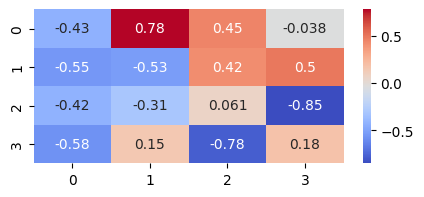

In [ ]:
U = np.array([np.sign(np.dot(A @ V[:, idx], U[:, idx])) * U[:, idx]
    for idx in range(U.shape[1])]).T
sns.heatmap(U, annot=True, cmap='coolwarm')

[特異値分解](https://manabitimes.jp/math/1280#5) $A=U\Sigma V^T$ の検算。

<Axes: >

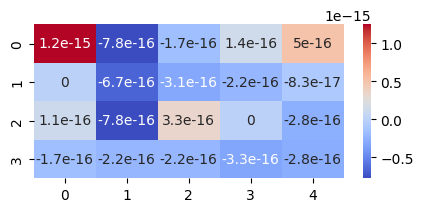

In [ ]:
residuals = A - (U @ Sigma @ V.T)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

numpy の標準機能でも特異値分解。

In [ ]:
U2, sigma2, V2h = la.svd(A)
print(sigma2)

[2.061 0.664 0.489 0.166]


特異ベクトルは符号の不定性があるため、対角化から求めた結果と一致するとは限らない。

sigma2-sigma=array([ 0.000e+00, -7.772e-16, -3.331e-16,  1.943e-16])


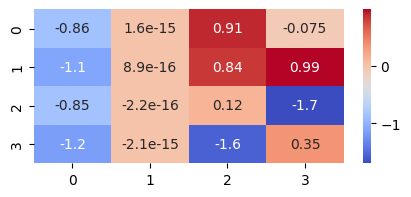

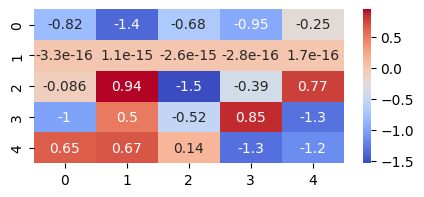

In [ ]:
import matplotlib.pyplot as plt

print(f"{sigma2-sigma=}")
sns.heatmap(U-U2, annot=True, cmap='coolwarm')
plt.show()
sns.heatmap(V.T - V2h, annot=True, cmap='coolwarm')
plt.show()

特異分解$A=U\Sigma V^T$はきちんと満たす。

<Axes: >

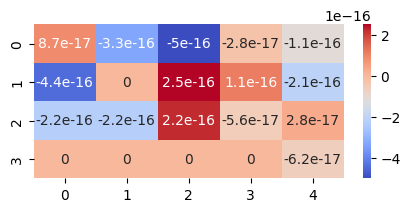

In [ ]:
Sigma2 = np.zeros_like(A)
sigma2 = sigma_right if len(sigma_right) < len(sigma_left) else sigma_left
Sigma2[:len(sigma2), :len(sigma2)] = np.diag(sigma2)
residuals = A - (U2 @ Sigma2 @ V2h)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

## 固有値計算

アーベル・ルフィニの定理より5次以上の代数方程式には公式が存在しない。よって5x5行列の特性方程式は直接的に解けないため、反復法を使用する。